In [4]:
# module imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import random
import re

# model imports
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# processing imports
from sklearn.preprocessing import LabelEncoder
from string import punctuation
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from termcolor import colored
nltk.download('stopwords')
stopwords.words("english")

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical

from keras.layers import Dense, LSTM, MaxPool1D, Flatten, Dropout, Conv1D, Activation, Embedding
from keras.models import Sequential
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Embedding, Dropout, Flatten, Bidirectional, SimpleRNN
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

# import pipeline and SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from warnings import filterwarnings
filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jhnkc\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
trd = pd.read_csv('a.csv')
ted = pd.read_csv('CEAS_08.csv')
tcd = pd.read_csv('b.csv', encoding='utf-8', on_bad_lines='skip')

In [ ]:
trd = trd.drop(columns=['Unnamed: 0'])
trd = trd.rename(columns = {"Email Text" : "Text", "Email Type" : "label"})
trd['label'].replace({'Safe Email': 0, 'Phishing Email': 1}, inplace=True)
trd.astype({'label': 'int64'}).dtypes
trd.info()
trd.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18650 entries, 0 to 18649
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    18634 non-null  object
 1   label   18650 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 291.5+ KB


,Text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
...,...,...
95,"enron / hpl actuals for june 6 , 2000 teco tap...",0
96,you ' ve been selected for the low rates progr...,1
97,A:link {TEX-DECORATION: none}A:active {TEXT-DE...,1
98,syntax of east asian languages workshop usc wo...,0


In [ ]:
ted["Text"] = ted["subject"] + " " + ted["body"]
ted = ted.drop(columns=['sender', 'receiver', 'date', 'subject', 'body', 'urls'])
ted = ted[['Text', 'label']]
ted.info()
ted.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39154 entries, 0 to 39153
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    39126 non-null  object
 1   label   39154 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 611.9+ KB


,Text,label
0,"Never agree to be a loser Buck up, your troubl...",1
1,Befriend Jenna Jameson \nUpgrade your sex and ...,1
2,CNN.com Daily Top 10 >+=+=+=+=+=+=+=+=+=+=+=+=...,1
3,Re: svn commit: r619753 - in /spamassassin/tru...,0
4,SpecialPricesPharmMoreinfo \nWelcomeFastShippi...,1
...,...,...
95,Re: [Python-Dev] Python-Dev Summary Draft (Apr...,0
96,Re: [Python-Dev] Python-Dev Summary Draft (Apr...,0
97,[Perl Jobs] Top NYC LAMP shop / B2B mod_perl /...,0
98,[SM-USERS] SM 1.4.13 Configuration Question: M...,0


In [ ]:
tcd["Text"] = tcd["subject"] + " " + tcd["body"]
tcd = tcd.drop(columns=['sender', 'receiver', 'date', 'subject', 'body', 'urls'])
tcd = tcd[['Text', 'label']]
tcd.info()
tcd.head(100)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53757 entries, 0 to 53756
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Text    53308 non-null  object
 1   label   53757 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 840.1+ KB


,Text,label
0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",1
1,"Typo in /debian/README Hi, i've just updated f...",0
2,authentic viagra Mega authenticV I A G R A ...,1
3,"Nice talking with ya \nHey Billy, \n\nit was r...",1
4,or trembling; stomach cramps; trouble in sleep...,1
...,...,...
95,Do not miss this opportunity for recovery \n\n...,1
96,How does Cialis work? What is Cialis?\n\nCial...,1
97,variety of styles Spring watches models\nLuxu...,1
98,30 Free digital camera prints from Snapfish \n...,1


Combined datasets (testing)

In [ ]:
frames = [trd, ted, tcd]
data_1 = pd.concat(frames)
data_1

In [ ]:
# Define the preprocessing function
def preprocess(Text):
    Text = re.sub(r'[^\w\s]', ' ', str(Text).lower()).strip()
    return Text

# Assuming 'data' is your DataFrame
data_1['Text'] = data_1['Text'].apply(preprocess)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=5000
)

# Split the dataset into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(data_1['Text'], data_1['label'], test_size=0.2, random_state=42)

# Fit the vectorizer on the training data and transform
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Reshape for LSTM and CNN
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# Convert labels to numpy array
y_train = np.array(y_train)
y_test = np.array(y_test)


2 training dataset and 1 testing dataset (used for results)

In [ ]:
frames = [trd, tcd]
data_2 = pd.concat(frames)
data_2

,Text,label
0,"re : 6 . 1100 , disc : uniformitarianism , re ...",0
1,the other side of * galicismos * * galicismo *...,0
2,re : equistar deal tickets are you still avail...,0
3,\nHello I am your hot lil horny toy.\n I am...,1
4,software at incredibly low prices ( 86 % lower...,1
...,...,...
53752,Job: just for you. \n\n\n\nWhile we may ...,1
53753,the reply for your request for a job place [le...,1
53754,"Re: [R] Me again, about the horrible documenta...",0
53755,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",0


In [ ]:
# Define the preprocessing function
def preprocess(Text):
    Text = re.sub(r'[^\w\s]', ' ', str(Text).lower()).strip()
    return Text

# Preprocess training and test data
data_2['Text'] = data_2['Text'].apply(preprocess)
ted['Text'] = ted['Text'].apply(preprocess)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=6000
)

# Fit the vectorizer on the training data and transform both datasets
X_train_tfidf = vectorizer.fit_transform(data_2['Text']).toarray()
X_test_tfidf = vectorizer.transform(ted['Text']).toarray()

# Reshape for LSTM and CNN
X_train_tfidf = X_train_tfidf.reshape(X_train_tfidf.shape[0], X_train_tfidf.shape[1], 1)
X_test_tfidf = X_test_tfidf.reshape(X_test_tfidf.shape[0], X_test_tfidf.shape[1], 1)

# Convert labels to numpy array
y_train = np.array(data_2['label'])
y_test = np.array(ted['label'])

Model

In [ ]:
# 1. ANN Model
def ann():
    model = Sequential(name="ANN")
    model.add(Dense(128, activation='relu', input_shape=(X_train_tfidf.shape[1],)))
    model.add(Dropout(0.5))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

#2. RNN Model
def rnn():
    model = Sequential(name="RNN")
    model.add(SimpleRNN(64, input_shape=(X_train_tfidf.shape[1], 1), return_sequences=False))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 3. CNN Model
def cnn():
    model = Sequential(name="CNN")
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# 4. CNN-LSTM Model
def cnn_lstm():
    model = Sequential(name="CNN-LSTM")
    model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=(X_train_tfidf.shape[1], 1)))
    model.add(Dropout(0.3))
    model.add(LSTM(64))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Train and evaluate each model
models = {
    # 'ANN': ann(),
    'RNN': rnn(),
    # 'CNN': cnn(),
    # 'CNN-LSTM': cnn_lstm()
}

Train the model

In [ ]:
# Define function to evaluate the model
def evaluate_model(model, X_test, y_test):
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    print(classification_report(y_test, y_pred))

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    # Train and evaluate all models
for model, model in models.items():
    print(f"\nTraining {model} model...")

    # Fit the model and store the history object
    history = model.fit(
        X_train_tfidf, y_train,
        epochs=50,
        batch_size=64,
        validation_split=0.2,
        callbacks=[early_stopping]
    )

    # Evaluate model
    print(f"Evaluating {model} model...")
    evaluate_model(model, X_test_tfidf, y_test)

    # Calculate train accuracy
    trainScore = model.evaluate(X_train_tfidf, y_train, verbose=0)
    print("Our accuracy is %{}".format(trainScore[1] * 100))


Training <Sequential name=RNN, built=True> model...
Epoch 1/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 577s 631ms/step - accuracy: 0.4980 - loss: 0.7125 - val_accuracy: 0.4635 - val_loss: 0.6953
Epoch 2/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 628s 642ms/step - accuracy: 0.5029 - loss: 0.6956 - val_accuracy: 0.4635 - val_loss: 0.6950
Epoch 3/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 621s 641ms/step - accuracy: 0.5044 - loss: 0.6945 - val_accuracy: 0.4635 - val_loss: 0.7000
Epoch 4/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 623s 642ms/step - accuracy: 0.5029 - loss: 0.6941 - val_accuracy: 0.5365 - val_loss: 0.6918
Epoch 5/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 602s 620ms/step - accuracy: 0.5038 - loss: 0.6939 - val_accuracy: 0.4635 - val_loss: 0.6948
Epoch 6/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 585s 646ms/step - accuracy: 0.4999 - loss: 0.6940 - val_accuracy: 0.4635 - val_loss: 0.6976
Epoch 7/50
906/906 ━━━━━━━━━━━━━━━━━━━━ 600s 621ms/step - accuracy: 0.5055 - loss: 0.6942 - val_accuracy: 0.4635 - val_loss: 0.6948
Epoch 8/50
906/906 ━━━━

Plotting the graph and confusion matrix


Evaluating model: RNN
Plotting loss graphs for RNN


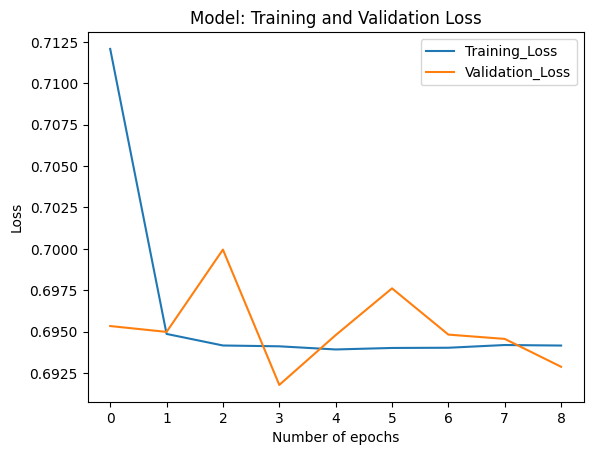

Plotting accuracy graphs for RNN


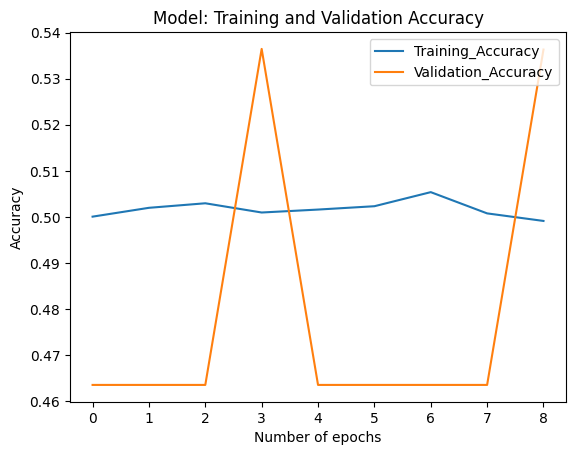

1224/1224 ━━━━━━━━━━━━━━━━━━━━ 127s 104ms/step
Plotting confusion matrix for RNN


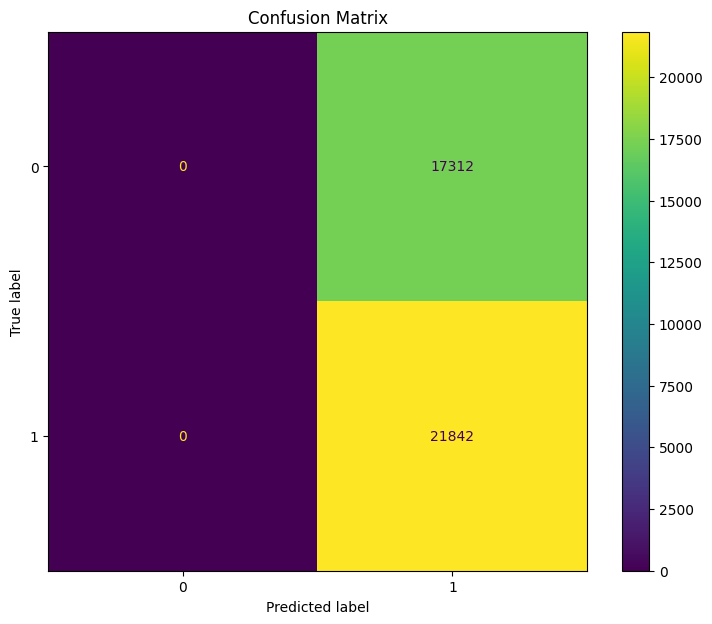

In [ ]:
# Function to plot training and validation metrics
def plot_graphs(var1, var2, string, metrics):
    metrics[[var1, var2]].plot()
    plt.title('Model: Training and Validation ' + string)
    plt.xlabel('Number of epochs')
    plt.ylabel(string)
    plt.legend([var1, var2])
    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(cm):
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    fig, ax = plt.subplots(figsize=(9, 7))
    disp.plot(ax=ax, cmap="viridis", colorbar=True)

    plt.title("Confusion Matrix")
    plt.show()

# Loop through each model
for model_name, model in models.items():
    # Print the model name for clarity
    print(f"\nEvaluating model: {model_name}\n{'='*40}")

    # Convert history to DataFrame for further analysis
    metrics = pd.DataFrame(history.history)

    # Rename columns to match desired format
    metrics.rename(columns={'loss': 'Training_Loss',
                            'accuracy': 'Training_Accuracy',
                            'val_loss': 'Validation_Loss',
                            'val_accuracy': 'Validation_Accuracy'}, inplace=True)

    # Print before plotting loss
    print(f"Plotting loss graphs for {model_name}")
    plot_graphs('Training_Loss', 'Validation_Loss', 'Loss', metrics)

    # Print before plotting accuracy
    print(f"Plotting accuracy graphs for {model_name}")
    plot_graphs('Training_Accuracy', 'Validation_Accuracy', 'Accuracy', metrics)

    # Predict and create confusion matrix
    y_pred = model.predict(X_test_tfidf)
    y_pred = (y_pred > 0.5)  # Adjust threshold if necessary
    cm = confusion_matrix(y_test, y_pred)

    # Print message before confusion matrix plot
    print(f"Plotting confusion matrix for {model_name}")
    plot_confusion_matrix(cm)


Machine Learning: Logistic Regression,
K-Neighbors,
Random Forest,
SVC

In [ ]:
# Define the preprocessing function
def preprocess(Text):
    Text = re.sub(r'[^\w\s]', ' ', str(Text).lower()).strip()
    return Text

# Preprocess training and test data
data_2['Text'] = data_2['Text'].apply(preprocess)
ted['Text'] = ted['Text'].apply(preprocess)

# Initialize TfidfVectorizer
vectorizer = TfidfVectorizer(
    stop_words='english',
    ngram_range=(1, 1),
    max_df=1.0,
    min_df=1,
    max_features=5000
)

# Fit the vectorizer on the training data and transform both datasets
X_train_tfidf = vectorizer.fit_transform(data_2['Text']).toarray()
X_test_tfidf = vectorizer.transform(ted['Text']).toarray()

# Convert labels to numpy array
y_train = np.array(data_2['label'])
y_test = np.array(ted['label'])

In [ ]:
# Initialize classifiers
models = {
    "SVC": SVC(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "K-Neighbors": KNeighborsClassifier()
}

# Train, predict, and evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train_tfidf, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test_tfidf)

    # Display classification report
    print(f"\n{model_name} Classification Report:\n", classification_report(y_test, y_pred))

    # Compute accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.2f} %")

    # Compute confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm',
                xticklabels=['Normal', 'Phishing'], yticklabels=['Normal', 'Phishing'])
    plt.title(f"Confusion Matrix for {model_name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()
